# Amazon Fine Food Reviews Analysis


Data Source: https://www.kaggle.com/snap/amazon-fine-food-reviews <br>

EDA: https://nycdatascience.com/blog/student-works/amazon-fine-foods-visualization/


The Amazon Fine Food Reviews dataset consists of reviews of fine foods from Amazon.<br>

Number of reviews: 568,454<br>
Number of users: 256,059<br>
Number of products: 74,258<br>
Timespan: Oct 1999 - Oct 2012<br>
Number of Attributes/Columns in data: 10 

Attribute Information:

1. Id
2. ProductId - unique identifier for the product
3. UserId - unqiue identifier for the user
4. ProfileName
5. HelpfulnessNumerator - number of users who found the review helpful
6. HelpfulnessDenominator - number of users who indicated whether they found the review helpful or not
7. Score - rating between 1 and 5
8. Time - timestamp for the review
9. Summary - brief summary of the review
10. Text - text of the review


#### Objective:
Given a review, determine whether the review is positive (rating of 4 or 5) or negative (rating of 1 or 2).

<br>
[Q] How to determine if a review is positive or negative?<br>
<br> 
[Ans] We could use Score/Rating. A rating of 4 or 5 can be cosnidered as a positive review. A rating of 1 or 2 can be considered as negative one. A review of rating 3 is considered nuetral and such reviews are ignored from our analysis. This is an approximate and proxy way of determining the polarity (positivity/negativity) of a review.




# [1]. Reading Data

## [1.1] Loading the data

The dataset is available in two forms
1. .csv file
2. SQLite Database

In order to load the data, We have used the SQLITE dataset as it is easier to query the data and visualise the data efficiently.
<br> 

Here as we only want to get the global sentiment of the recommendations (positive or negative), we will purposefully ignore all Scores equal to 3. If the score is above 3, then the recommendation wil be set to "positive". Otherwise, it will be set to "negative".

In [1]:
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")


import sqlite3
import pandas as pd
import numpy as np
import nltk
import string
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn import cross_validation

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.metrics import roc_curve, auc
from nltk.stem.porter import PorterStemmer
from sklearn.metrics import confusion_matrix
from scipy.sparse import csr_matrix
from scipy import sparse
from sklearn import metrics
from sklearn import preprocessing
from sklearn.metrics import roc_curve, auc
from nltk.stem.porter import PorterStemmer
from sklearn import model_selection
from sklearn.decomposition import TruncatedSVD
import seaborn as sns
from sklearn.naive_bayes import MultinomialNB
from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score
from sklearn.model_selection import cross_validate
from collections import Counter
from sklearn.metrics import precision_score
from sklearn.metrics import f1_score
from sklearn.metrics import recall_score
from sklearn.model_selection import train_test_split

import re
# Tutorial about Python regular expressions: https://pymotw.com/2/re/
import string
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.stem.wordnet import WordNetLemmatizer

from gensim.models import Word2Vec
from gensim.models import KeyedVectors
import pickle

from tqdm import tqdm
import os

ImportError: cannot import name 'cross_validation'

In [2]:
# using SQLite Table to read data.
# con = sqlite3.connect('database.sqlite') 
con = sqlite3.connect('C:\\Users\\rahul\\Desktop\\AI COURSE\\Amazon Fine food\\amazon-fine-food-reviews (1)\\database.sqlite')

# filtering only positive and negative reviews i.e. 
# not taking into consideration those reviews with Score=3
# SELECT * FROM Reviews WHERE Score != 3 LIMIT 500000, will give top 500000 data points
# you can change the number to any other number based on your computing power

# filtered_data = pd.read_sql_query(""" SELECT * FROM Reviews WHERE Score != 3 LIMIT 500000""", con) 
# for tsne assignment you can take 5k data points

filtered_data = pd.read_sql_query(""" SELECT * FROM Reviews WHERE Score != 3""", con) 

# Give reviews with Score>3 a positive rating(1), and reviews with a score<3 a negative rating(0).
def partition(x):
    if x < 3:
        return 0
    return 1

#changing reviews with score less than 3 to be positive and vice-versa
actualScore = filtered_data['Score']
positiveNegative = actualScore.map(partition) 
filtered_data['Score'] = positiveNegative
print("Number of data points in our data", filtered_data.shape)
filtered_data.head(3)

Number of data points in our data (525814, 10)


,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,1,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
1,2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,0,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
2,3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,1,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...


In [43]:
display = pd.read_sql_query("""
SELECT UserId, ProductId, ProfileName, Time, Score, Text, COUNT(*)
FROM Reviews
GROUP BY UserId
HAVING COUNT(*)>1
""", con)

In [44]:
print(display.shape)
display.head()

(80668, 7)


,UserId,ProductId,ProfileName,Time,Score,Text,COUNT(*)
0,#oc-R115TNMSPFT9I7,B007Y59HVM,Breyton,1331510400,2,Overall its just OK when considering the price...,2
1,#oc-R11D9D7SHXIJB9,B005HG9ET0,"Louis E. Emory ""hoppy""",1342396800,5,"My wife has recurring extreme muscle spasms, u...",3
2,#oc-R11DNU2NBKQ23Z,B007Y59HVM,Kim Cieszykowski,1348531200,1,This coffee is horrible and unfortunately not ...,2
3,#oc-R11O5J5ZVQE25C,B005HG9ET0,Penguin Chick,1346889600,5,This will be the bottle that you grab from the...,3
4,#oc-R12KPBODL2B5ZD,B007OSBE1U,Christopher P. Presta,1348617600,1,I didnt like this coffee. Instead of telling y...,2


In [45]:
display[display['UserId']=='AZY10LLTJ71NX']

,UserId,ProductId,ProfileName,Time,Score,Text,COUNT(*)
80638,AZY10LLTJ71NX,B006P7E5ZI,"undertheshrine ""undertheshrine""",1334707200,5,I was recommended to try green tea extract to ...,5


In [46]:
display['COUNT(*)'].sum()

393063

#  [2] Exploratory Data Analysis

## [2.1] Data Cleaning: Deduplication

It is observed (as shown in the table below) that the reviews data had many duplicate entries. Hence it was necessary to remove duplicates in order to get unbiased results for the analysis of the data.  Following is an example:

In [47]:
display= pd.read_sql_query("""
SELECT *
FROM Reviews
WHERE Score != 3 AND UserId="AR5J8UI46CURR"
ORDER BY ProductID
""", con)
display.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,78445,B000HDL1RQ,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
1,138317,B000HDOPYC,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
2,138277,B000HDOPYM,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
3,73791,B000HDOPZG,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
4,155049,B000PAQ75C,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...


As it can be seen above that same user has multiple reviews with same values for HelpfulnessNumerator, HelpfulnessDenominator, Score, Time, Summary and Text and on doing analysis it was found that <br>
<br> 
ProductId=B000HDOPZG was Loacker Quadratini Vanilla Wafer Cookies, 8.82-Ounce Packages (Pack of 8)<br>
<br> 
ProductId=B000HDL1RQ was Loacker Quadratini Lemon Wafer Cookies, 8.82-Ounce Packages (Pack of 8) and so on<br>

It was inferred after analysis that reviews with same parameters other than ProductId belonged to the same product just having different flavour or quantity. Hence in order to reduce redundancy it was decided to eliminate the rows having same parameters.<br>

The method used for the same was that we first sort the data according to ProductId and then just keep the first similar product review and delelte the others. for eg. in the above just the review for ProductId=B000HDL1RQ remains. This method ensures that there is only one representative for each product and deduplication without sorting would lead to possibility of different representatives still existing for the same product.

In [3]:
#Sorting data according to ProductId in ascending order
sorted_data=filtered_data.sort_values('ProductId', axis=0, ascending=True, inplace=False, kind='quicksort', na_position='last')

In [4]:
#Deduplication of entries
final=sorted_data.drop_duplicates(subset={"UserId","ProfileName","Time","Text"}, keep='first', inplace=False)

In [50]:
#Checking to see how much % of data still remains
(final['Id'].size*1.0)/(filtered_data['Id'].size*1.0)*100

69.25890143662969

<b>Observation:-</b> It was also seen that in two rows given below the value of HelpfulnessNumerator is greater than HelpfulnessDenominator which is not practically possible hence these two rows too are removed from calcualtions

In [51]:
display= pd.read_sql_query("""
SELECT *
FROM Reviews
WHERE Score != 3 AND Id=44737 OR Id=64422
ORDER BY ProductID
""", con)

display.head()

,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
0,64422,B000MIDROQ,A161DK06JJMCYF,"J. E. Stephens ""Jeanne""",3,1,5,1224892800,Bought This for My Son at College,My son loves spaghetti so I didn't hesitate or...
1,44737,B001EQ55RW,A2V0I904FH7ABY,Ram,3,2,4,1212883200,Pure cocoa taste with crunchy almonds inside,It was almost a 'love at first bite' - the per...


In [5]:
final=final[final.HelpfulnessNumerator<=final.HelpfulnessDenominator]

In [6]:
#Before starting the next phase of preprocessing lets see the number of entries left
final = sorted_data.sample(n=100000)
final.shape

print(final.shape)

#How many positive and negative reviews are present in our dataset?
final['Score'].value_counts()

(100000, 10)


1    84328
0    15672
Name: Score, dtype: int64

#  [3] Preprocessing

## [3.1].  Preprocessing Review Text

Now that we have finished deduplication our data requires some preprocessing before we go on further with analysis and making the prediction model.

Hence in the Preprocessing phase we do the following in the order below:-

1. Begin by removing the html tags
2. Remove any punctuations or limited set of special characters like , or . or # etc.
3. Check if the word is made up of english letters and is not alpha-numeric
4. Check to see if the length of the word is greater than 2 (as it was researched that there is no adjective in 2-letters)
5. Convert the word to lowercase
6. Remove Stopwords
7. Finally Snowball Stemming the word (it was obsereved to be better than Porter Stemming)<br>

After which we collect the words used to describe positive and negative reviews

In [7]:
# printing some random reviews
sent_0 = final['Text'].values[0]
print(sent_0)
print("="*50)

sent_1000 = final['Text'].values[1000]
print(sent_1000)
print("="*50)

sent_1500 = final['Text'].values[1500]
print(sent_1500)
print("="*50)

sent_4900 = final['Text'].values[4900]
print(sent_4900)
print("="*50)

I love this stuff.  I'd been drinking Twinings English Breakfast for years.  When my Mom asked for Christmas gift ideas last year, I mentioned loose tea and told her that was my favorite.  I opened gifts on Christmas morning to find my first bag of Taylors of Harrogate Yorkshire Tea -- she hadn't been able to find Twinings loose leaf.<br /><br />I make it using an individual french press mug set (a Christmas gift from my brother a couple of years ago!), and it's the best tea I've ever had.  I liked it so much I didn't even think twice about ordering the box of 6...and I may be asking for more by the time Christmas rolls around again!
I own an espresso machine and love coffee. However the machine is a pain to use when I'm in a rush to work in the morning, which is most mornings.  I was thinking about getting a Keurig pod machine to make my mornings easier, however I didn't want to have yet another appliance sitting on my counter.  Then I remembered that my espresso maker came with an ES

In [8]:
# remove urls from text python: https://stackoverflow.com/a/40823105/4084039
sent_0 = re.sub(r"http\S+", "", sent_0)
sent_1000 = re.sub(r"http\S+", "", sent_1000)
sent_150 = re.sub(r"http\S+", "", sent_1500)
sent_4900 = re.sub(r"http\S+", "", sent_4900)

print(sent_0)

I love this stuff.  I'd been drinking Twinings English Breakfast for years.  When my Mom asked for Christmas gift ideas last year, I mentioned loose tea and told her that was my favorite.  I opened gifts on Christmas morning to find my first bag of Taylors of Harrogate Yorkshire Tea -- she hadn't been able to find Twinings loose leaf.<br /><br />I make it using an individual french press mug set (a Christmas gift from my brother a couple of years ago!), and it's the best tea I've ever had.  I liked it so much I didn't even think twice about ordering the box of 6...and I may be asking for more by the time Christmas rolls around again!


In [9]:
# https://stackoverflow.com/questions/16206380/python-beautifulsoup-how-to-remove-all-tags-from-an-element
from bs4 import BeautifulSoup

soup = BeautifulSoup(sent_0, 'lxml')
text = soup.get_text()
print(text)
print("="*50)

soup = BeautifulSoup(sent_1000, 'lxml')
text = soup.get_text()
print(text)
print("="*50)

soup = BeautifulSoup(sent_1500, 'lxml')
text = soup.get_text()
print(text)
print("="*50)

soup = BeautifulSoup(sent_4900, 'lxml')
text = soup.get_text()
print(text)

I love this stuff.  I'd been drinking Twinings English Breakfast for years.  When my Mom asked for Christmas gift ideas last year, I mentioned loose tea and told her that was my favorite.  I opened gifts on Christmas morning to find my first bag of Taylors of Harrogate Yorkshire Tea -- she hadn't been able to find Twinings loose leaf.I make it using an individual french press mug set (a Christmas gift from my brother a couple of years ago!), and it's the best tea I've ever had.  I liked it so much I didn't even think twice about ordering the box of 6...and I may be asking for more by the time Christmas rolls around again!
I own an espresso machine and love coffee. However the machine is a pain to use when I'm in a rush to work in the morning, which is most mornings.  I was thinking about getting a Keurig pod machine to make my mornings easier, however I didn't want to have yet another appliance sitting on my counter.  Then I remembered that my espresso maker came with an ESE (easy serv

In [10]:
# https://stackoverflow.com/a/47091490/4084039
import re

def decontracted(phrase):
    # specific
    phrase = re.sub(r"won't", "will not", phrase)
    phrase = re.sub(r"can\'t", "can not", phrase)

    # general
    phrase = re.sub(r"n\'t", " not", phrase)
    phrase = re.sub(r"\'re", " are", phrase)
    phrase = re.sub(r"\'s", " is", phrase)
    phrase = re.sub(r"\'d", " would", phrase)
    phrase = re.sub(r"\'ll", " will", phrase)
    phrase = re.sub(r"\'t", " not", phrase)
    phrase = re.sub(r"\'ve", " have", phrase)
    phrase = re.sub(r"\'m", " am", phrase)
    return phrase

In [11]:
sent_1000 = decontracted(sent_1000)
print(sent_1000)
print("="*50)

I own an espresso machine and love coffee. However the machine is a pain to use when I am in a rush to work in the morning, which is most mornings.  I was thinking about getting a Keurig pod machine to make my mornings easier, however I did not want to have yet another appliance sitting on my counter.  Then I remembered that my espresso maker came with an ESE (easy serve espresso) pod adapter so I decided to give these pods a try based on the good reviews.<br /><br />Although clean up is a lot easier, the coffee pods are a bit weak in flavor.  I make Americanos in the morning, and one pod in 8oz of water is not quite strong enough for me.  Two pods is perfect.  I will no doubt need to use 4 pods for my travel mug to get the bold flavor that I desire.  Overall, the coffee is good and cleanup is easy.


In [59]:
#remove words with numbers python: https://stackoverflow.com/a/18082370/4084039
sent_0 = re.sub("\S*\d\S*", "", sent_0).strip()
print(sent_0)

My two cats somehow never figured out how to use their teeth to bite into their food--given dry food, they'll just use their tongues to lick it up and swallow the kernels whole, with an occasional bite with the teeth to crunch on food that's already been delivered into their mouths.  For a while I despaired of getting them to eat wet food, as they would just sit there and lick up all the juices, without getting much of the meat.  Typical canned food is just packed too tight, and the texture is not amenable for breaking off little bits with just their tongues.  Finally, I tried out Spot's Stew, which solved the problem.  This food is much looser, I think due to the inclusion of peas and other veggies, and the meat part is just the right consistency where they can lick it up successfully.  At first the cats would eat around the veggies, but they now lick up every morsel, and even prefer the Spot's Stew over the Wellness pouches.  I also like that the food doesn't contain any fish, as one

In [60]:
#remove spacial character: https://stackoverflow.com/a/5843547/4084039
sent_1500 = re.sub('[^A-Za-z0-9]+', ' ', sent_1500)
print(sent_1500)

I wish I had paid more attention to the reviews This product is pricey for what you get the little burned piece of cheese on the pan from some cheese dish It is so salty and so not worth it It s not a taste treat It is 1 carb of never mind Do not waste your money or taste buds on this 


In [12]:
# https://gist.github.com/sebleier/554280
# we are removing the words from the stop words list: 'no', 'nor', 'not'
# <br /><br /> ==> after the above steps, we are getting "br br"
# we are including them into stop words list
# instead of <br /> if we have <br/> these tags would have revmoved in the 1st step

stopwords= set(['br', 'the', 'i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've",\
            "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', \
            'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their',\
            'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', \
            'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', \
            'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', \
            'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after',\
            'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further',\
            'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more',\
            'most', 'other', 'some', 'such', 'only', 'own', 'same', 'so', 'than', 'too', 'very', \
            's', 't', 'can', 'will', 'just', 'don', "don't", 'should', "should've", 'now', 'd', 'll', 'm', 'o', 're', \
            've', 'y', 'ain', 'aren', "aren't", 'couldn', "couldn't", 'didn', "didn't", 'doesn', "doesn't", 'hadn',\
            "hadn't", 'hasn', "hasn't", 'haven', "haven't", 'isn', "isn't", 'ma', 'mightn', "mightn't", 'mustn',\
            "mustn't", 'needn', "needn't", 'shan', "shan't", 'shouldn', "shouldn't", 'wasn', "wasn't", 'weren', "weren't", \
            'won', "won't", 'wouldn', "wouldn't"])

In [13]:
# Combining all the above stundents 
from tqdm import tqdm
preprocessed_reviews = []
# tqdm is for printing the status bar
for sentance in tqdm(final['Text'].values):
    sentance = re.sub(r"http\S+", "", sentance)
    sentance = BeautifulSoup(sentance, 'lxml').get_text()
    sentance = decontracted(sentance)
    sentance = re.sub("\S*\d\S*", "", sentance).strip()
    sentance = re.sub('[^A-Za-z]+', ' ', sentance)
    # https://gist.github.com/sebleier/554280
    sentance = ' '.join(e.lower() for e in sentance.split() if e.lower() not in stopwords)
    preprocessed_reviews.append(sentance.strip())
    
preprocessed_summary = [] 
for sentence in tqdm(final['Summary'].values):
    sentence = re.sub(r"http\S+", "", sentence)
    sentence = BeautifulSoup(sentence, 'lxml').get_text()
    sentence = decontracted(sentence)
    sentence = re.sub("\S*\d\S*", "", sentence).strip()
    sentence = re.sub('[^A-Za-z]+', ' ', sentence)
    # https://gist.github.com/sebleier/554280
    sentence = ' '.join(e.lower() for e in sentence.split() if e.lower() not in stopwords)
    preprocessed_summary.append(sentence.strip())

100%|████████████████████████████████████████████████████████████████████████| 100000/100000 [00:38<00:00, 2582.66it/s]


In [14]:
print(preprocessed_reviews[1500])

tea perfect amount mint not strong not bitter liked tea much started buying tea bags


<h2><font color='red'>[3.2] Preprocessing Review Summary</font></h2>

In [15]:
## Similartly you can do preprocessing for review summary also.
print(preprocessed_summary[1500])

great mint flavor


In [16]:
## Take length of each review and use it as a feature
review_len = [len(i) for i in preprocessed_reviews]
#Add summary text and review text to extract as much information as possible
# interlist element concatenation 
combined_text = [i +' '+ j for i, j in zip(preprocessed_reviews, preprocessed_summary)] 

len(review_len)

final['combined_text'] = combined_text
final['review_length'] = review_len

# [4] Featurization

## [4.1] BAG OF WORDS

In [0]:
#BoW
count_vect = CountVectorizer() #in scikit-learn
count_vect.fit(preprocessed_reviews)
print("some feature names ", count_vect.get_feature_names()[:10])
print('='*50)

final_counts = count_vect.transform(preprocessed_reviews)
print("the type of count vectorizer ",type(final_counts))
print("the shape of out text BOW vectorizer ",final_counts.get_shape())
print("the number of unique words ", final_counts.get_shape()[1])

some feature names  ['aa', 'aahhhs', 'aback', 'abandon', 'abates', 'abbott', 'abby', 'abdominal', 'abiding', 'ability']
the type of count vectorizer  <class 'scipy.sparse.csr.csr_matrix'>
the shape of out text BOW vectorizer  (4986, 12997)
the number of unique words  12997


## [4.2] Bi-Grams and n-Grams.

In [0]:
#bi-gram, tri-gram and n-gram

#removing stop words like "not" should be avoided before building n-grams
# count_vect = CountVectorizer(ngram_range=(1,2))
# please do read the CountVectorizer documentation http://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.text.CountVectorizer.html

# you can choose these numebrs min_df=10, max_features=5000, of your choice
count_vect = CountVectorizer(ngram_range=(1,2), min_df=10, max_features=5000)
final_bigram_counts = count_vect.fit_transform(preprocessed_reviews)
print("the type of count vectorizer ",type(final_bigram_counts))
print("the shape of out text BOW vectorizer ",final_bigram_counts.get_shape())
print("the number of unique words including both unigrams and bigrams ", final_bigram_counts.get_shape()[1])

the type of count vectorizer  <class 'scipy.sparse.csr.csr_matrix'>
the shape of out text BOW vectorizer  (4986, 3144)
the number of unique words including both unigrams and bigrams  3144


## [4.3] TF-IDF

In [0]:
tf_idf_vect = TfidfVectorizer(ngram_range=(1,2), min_df=10)
tf_idf_vect.fit(preprocessed_reviews)
print("some sample features(unique words in the corpus)",tf_idf_vect.get_feature_names()[0:10])
print('='*50)

final_tf_idf = tf_idf_vect.transform(preprocessed_reviews)
print("the type of count vectorizer ",type(final_tf_idf))
print("the shape of out text TFIDF vectorizer ",final_tf_idf.get_shape())
print("the number of unique words including both unigrams and bigrams ", final_tf_idf.get_shape()[1])

some sample features(unique words in the corpus) ['ability', 'able', 'able find', 'able get', 'absolute', 'absolutely', 'absolutely delicious', 'absolutely love', 'absolutely no', 'according']
the type of count vectorizer  <class 'scipy.sparse.csr.csr_matrix'>
the shape of out text TFIDF vectorizer  (4986, 3144)
the number of unique words including both unigrams and bigrams  3144


## [4.4] Word2Vec

In [0]:
# Train your own Word2Vec model using your own text corpus
i=0
list_of_sentance=[]
for sentance in preprocessed_reviews:
    list_of_sentance.append(sentance.split())

In [0]:
# Using Google News Word2Vectors

# in this project we are using a pretrained model by google
# its 3.3G file, once you load this into your memory 
# it occupies ~9Gb, so please do this step only if you have >12G of ram
# we will provide a pickle file wich contains a dict , 
# and it contains all our courpus words as keys and  model[word] as values
# To use this code-snippet, download "GoogleNews-vectors-negative300.bin" 
# from https://drive.google.com/file/d/0B7XkCwpI5KDYNlNUTTlSS21pQmM/edit
# it's 1.9GB in size.


# http://kavita-ganesan.com/gensim-word2vec-tutorial-starter-code/#.W17SRFAzZPY
# you can comment this whole cell
# or change these varible according to your need

is_your_ram_gt_16g=False
want_to_use_google_w2v = False
want_to_train_w2v = True

if want_to_train_w2v:
    # min_count = 5 considers only words that occured atleast 5 times
    w2v_model=Word2Vec(list_of_sentance,min_count=5,size=50, workers=4)
    print(w2v_model.wv.most_similar('great'))
    print('='*50)
    print(w2v_model.wv.most_similar('worst'))
    
elif want_to_use_google_w2v and is_your_ram_gt_16g:
    if os.path.isfile('GoogleNews-vectors-negative300.bin'):
        w2v_model=KeyedVectors.load_word2vec_format('GoogleNews-vectors-negative300.bin', binary=True)
        print(w2v_model.wv.most_similar('great'))
        print(w2v_model.wv.most_similar('worst'))
    else:
        print("you don't have gogole's word2vec file, keep want_to_train_w2v = True, to train your own w2v ")

[('snack', 0.9951335191726685), ('calorie', 0.9946465492248535), ('wonderful', 0.9946032166481018), ('excellent', 0.9944332838058472), ('especially', 0.9941144585609436), ('baked', 0.9940600395202637), ('salted', 0.994047224521637), ('alternative', 0.9937226176261902), ('tasty', 0.9936816692352295), ('healthy', 0.9936649799346924)]
[('varieties', 0.9994194507598877), ('become', 0.9992934465408325), ('popcorn', 0.9992750883102417), ('de', 0.9992610216140747), ('miss', 0.9992451071739197), ('melitta', 0.999218761920929), ('choice', 0.9992102384567261), ('american', 0.9991837739944458), ('beef', 0.9991780519485474), ('finish', 0.9991567134857178)]


In [0]:
w2v_words = list(w2v_model.wv.vocab)
print("number of words that occured minimum 5 times ",len(w2v_words))
print("sample words ", w2v_words[0:50])

number of words that occured minimum 5 times  3817
sample words  ['product', 'available', 'course', 'total', 'pretty', 'stinky', 'right', 'nearby', 'used', 'ca', 'not', 'beat', 'great', 'received', 'shipment', 'could', 'hardly', 'wait', 'try', 'love', 'call', 'instead', 'removed', 'easily', 'daughter', 'designed', 'printed', 'use', 'car', 'windows', 'beautifully', 'shop', 'program', 'going', 'lot', 'fun', 'everywhere', 'like', 'tv', 'computer', 'really', 'good', 'idea', 'final', 'outstanding', 'window', 'everybody', 'asks', 'bought', 'made']


## [4.4.1] Converting text into vectors using Avg W2V, TFIDF-W2V

#### [4.4.1.1] Avg W2v

In [0]:
# average Word2Vec
# compute average word2vec for each review.
sent_vectors = []; # the avg-w2v for each sentence/review is stored in this list
for sent in tqdm(list_of_sentance): # for each review/sentence
    sent_vec = np.zeros(50) # as word vectors are of zero length 50, you might need to change this to 300 if you use google's w2v
    cnt_words =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words:
            vec = w2v_model.wv[word]
            sent_vec += vec
            cnt_words += 1
    if cnt_words != 0:
        sent_vec /= cnt_words
    sent_vectors.append(sent_vec)
print(len(sent_vectors))
print(len(sent_vectors[0]))

100%|████████████████████████████████████████████████████████████████████████████| 4986/4986 [00:03<00:00, 1330.47it/s]


4986
50


#### [4.4.1.2] TFIDF weighted W2v

In [0]:
# S = ["abc def pqr", "def def def abc", "pqr pqr def"]
model = TfidfVectorizer()
tf_idf_matrix = model.fit_transform(preprocessed_reviews)
# we are converting a dictionary with word as a key, and the idf as a value
dictionary = dict(zip(model.get_feature_names(), list(model.idf_)))

In [0]:
# TF-IDF weighted Word2Vec
tfidf_feat = model.get_feature_names() # tfidf words/col-names
# final_tf_idf is the sparse matrix with row= sentence, col=word and cell_val = tfidf

tfidf_sent_vectors = []; # the tfidf-w2v for each sentence/review is stored in this list
row=0;
for sent in tqdm(list_of_sentance): # for each review/sentence 
    sent_vec = np.zeros(50) # as word vectors are of zero length
    weight_sum =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words and word in tfidf_feat:
            vec = w2v_model.wv[word]
#             tf_idf = tf_idf_matrix[row, tfidf_feat.index(word)]
            # to reduce the computation we are 
            # dictionary[word] = idf value of word in whole courpus
            # sent.count(word) = tf valeus of word in this review
            tf_idf = dictionary[word]*(sent.count(word)/len(sent))
            sent_vec += (vec * tf_idf)
            weight_sum += tf_idf
    if weight_sum != 0:
        sent_vec /= weight_sum
    tfidf_sent_vectors.append(sent_vec)
    row += 1

100%|█████████████████████████████████████████████████████████████████████████████| 4986/4986 [00:20<00:00, 245.63it/s]


# [5] Assignment 4: Apply Naive Bayes

<ol>
    <li><strong>Apply Multinomial NaiveBayes on these feature sets</strong>
        <ul>
            <li><font color='red'>SET 1:</font>Review text, preprocessed one converted into vectors using (BOW)</li>
            <li><font color='red'>SET 2:</font>Review text, preprocessed one converted into vectors using (TFIDF)</li>
        </ul>
    </li>
    <br>
    <li><strong>The hyper paramter tuning(find best Alpha)</strong>
        <ul>
    <li>Find the best hyper parameter which will give the maximum <a href='https://www.appliedaicourse.com/course/applied-ai-course-online/lessons/receiver-operating-characteristic-curve-roc-curve-and-auc-1/'>AUC</a> value</li>
    <li>Consider a wide range of alpha values for hyperparameter tuning, start as low as 0.00001</li>
    <li>Find the best hyper paramter using k-fold cross validation or simple cross validation data</li>
    <li>Use gridsearch cv or randomsearch cv or you can also write your own for loops to do this task of hyperparameter tuning</li>
        </ul>
    </li>
    <br>
    <li><strong>Feature importance</strong>
        <ul>
    <li>Find the top 10 features of positive class and top 10 features of negative class for both feature sets <font color='red'>Set 1</font> and <font color='red'>Set 2</font> using values of `feature_log_prob_` parameter of  <a href='https://scikit-learn.org/stable/modules/generated/sklearn.naive_bayes.MultinomialNB.html'>MultinomialNB</a> and print their corresponding feature names</li>
        </ul>
    </li>
    <br>
    <li><strong>Feature engineering</strong>
        <ul>
    <li>To increase the performance of your model, you can also experiment with with feature engineering like :</li>
            <ul>
            <li>Taking length of reviews as another feature.</li>
            <li>Considering some features from review summary as well.</li>
        </ul>
        </ul>
    </li>
    <br>
    <li><strong>Representation of results</strong>
        <ul>
    <li>You need to plot the performance of model both on train data and cross validation data for each hyper parameter, like shown in the figure. Here on X-axis you will have alpha values, since they have a wide range, just to represent those alpha values on the graph, apply log function on those alpha values.
    <img src='train_cv_auc.JPG' width=300px></li>
    <li>Once after you found the best hyper parameter, you need to train your model with it, and find the AUC on test data and plot the ROC curve on both train and test.
    <img src='train_test_auc.JPG' width=300px></li>
    <li>Along with plotting ROC curve, you need to print the <a href='https://www.appliedaicourse.com/course/applied-ai-course-online/lessons/confusion-matrix-tpr-fpr-fnr-tnr-1/'>confusion matrix</a> with predicted and original labels of test data points. Please visualize your confusion matrices using <a href='https://seaborn.pydata.org/generated/seaborn.heatmap.html'>seaborn heatmaps.
    <img src='confusion_matrix.png' width=300px></li>
        </ul>
    </li>
    <br>
    <li><strong>Conclusion</strong>
        <ul>
    <li>You need to summarize the results at the end of the notebook, summarize it in the table format. To print out a table please refer to this prettytable library<a href='http://zetcode.com/python/prettytable/'>  link</a> 
        <img src='summary.JPG' width=400px>
    </li>
        </ul>
</ol>

<h4><font color='red'>Note: Data Leakage</font></h4>

1. There will be an issue of data-leakage if you vectorize the entire data and then split it into train/cv/test.
2. To avoid the issue of data-leakag, make sure to split your data first and then vectorize it. 
3. While vectorizing your data, apply the method fit_transform() on you train data, and apply the method transform() on cv/test data.
4. For more details please go through this <a href='https://soundcloud.com/applied-ai-course/leakage-bow-and-tfidf'>link.</a>

# Applying Multinomial Naive Bayes

## [5.1] Applying Naive Bayes on BOW,<font color='red'> SET 1</font>

In [17]:
# Please write all the code with proper documentation
label = final['Score']

# split the data set into train and test
X_train, X_test, y_train, y_test = cross_validation.train_test_split(final, label, test_size=0.3, random_state=0)

type(final)
print(final.head(3))

#Bag of words using Scikit learn
count_vect = CountVectorizer()
vocab = count_vect.fit(X_train['combined_text'].values)
type(vocab)


# #Using the vocab obtained in train to vectorize both train and test data
X_train_bow = vocab.transform(X_train['combined_text'].values)
X_test_bow = vocab.transform(X_test['combined_text'].values)

print(X_train_bow.shape)

X_train_len = X_train['review_length']
X_test_len = X_test['review_length']
X_train_len = X_train_len.values
X_test_len = X_test_len.values

X_train_len = X_train_len.reshape(X_train_len.size,1)
X_test_len = X_test_len.reshape(X_test_len.size,1)


X_train_len = sparse.coo_matrix(X_train_len)
X_test_len = sparse.coo_matrix(X_test_len)

X_trainf = sparse.vstack((X_train_bow.T,X_train_len.T)).T
X_testf = sparse.vstack((X_test_bow.T,X_test_len.T)).T

print(X_trainf.shape)
print(X_testf.shape)

            Id   ProductId          UserId     ProfileName  \
147596  160143  B000F3WSFC  A3IJ4RQXTHQ56C              MJ   
61747    67080  B0006348H2  A3EAP0PTGE5KBQ   wvrivergirl40   
347537  375927  B0000DBN1O  A1IU7S4HCK1XK0  Joanna Daneman   

        HelpfulnessNumerator  HelpfulnessDenominator  Score        Time  \
147596                     0                       0      1  1299196800   
61747                      1                       1      1  1311811200   
347537                     7                       7      1  1072656000   

                                           Summary  \
147596           Makes a Lovely Cup of Tea, Indeed   
61747   Pet will eat it if you mix with their food   
347537                              Earl Grey, Hot   

                                                     Text  \
147596  I love this stuff.  I'd been drinking Twinings...   
61747   It grows really fast, but my dog and cat will ...   
347537  This is a strongly aromatic version of Ear

In [18]:
from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import cross_validate

#function to find the optimal alpha in NB for 5 fold cross validation

def find_optimal_alpha(x,y,n):
    # creating a list of alpha for NB
    alpha_list = [0.00001,.0001,.001,.01,.1,1,10,100,1000,10000]
    
    # empty list that will hold train scores
    train_scores = []
    cv_scores = []
    

# perform 5-fold cross validation 

#dropping the prior probabilities as we have higly imbalanced data
#using roc_auc as our test metric
    for alpha in alpha_list:
        clf = MultinomialNB(alpha=alpha, fit_prior=False)
        scores = cross_validate(clf, x, y, cv=n, scoring='roc_auc',  return_train_score=True)
        train_scores.append(scores['train_score'].mean())
        cv_scores.append(scores['test_score'].mean())

# changing to misclassification error (error = 1 - accuracy)
    MSE_cv = [1 - x for x in cv_scores]
    MSE_train = [1 - x for x in train_scores]

# determining best alpha
    optimal_alpha = alpha_list[cv_scores.index(max(cv_scores))]
    print('\nThe optimal value of alpha is %f.' % optimal_alpha)
    
#taking log of the values for graph to maintain the scale
    log_alpha = np.log(alpha_list)
    
    plt.figure(figsize=(16,8))
# plot misclassification error vs k 
    plt.plot(log_alpha, cv_scores,label='CV_plot')
    plt.plot(log_alpha, train_scores,label= 'Train_plot')

    for xy in zip(np.round(log_alpha,3), np.round(cv_scores,3)):
        plt.annotate('(%s, %s)' % xy, xy=xy, textcoords='data')

    for xy in zip(np.round(log_alpha,3), np.round(train_scores,3)):
        plt.annotate('(%s, %s)' % xy, xy=xy, textcoords='data')

    plt.xlabel('Log-Value of alpha ')
    plt.ylabel('AUC Score')
    plt.legend()
    plt.show()

    print("the AUC score for each alpha value is : ", np.round(cv_scores,3))
    return optimal_alpha
#     # ============================== Naive Bayes with alpha = optimal_alpha ===============================================
# instantiate learning model k = optimal_k

#function to predict the label of test data and return the same as list 
def pred_test_data(x_tr,y_tr,x_tst,y_tst,optimal_alpha,model):
    NB_optimal = MultinomialNB(alpha=optimal_alpha, fit_prior=False)

    # fitting the model
    NB_optimal.fit(x_tr, y_tr)

    # predict the response
    prob = NB_optimal.predict_proba(x_tst)[:,1]
    
    pred = NB_optimal.predict(x_tst)
    # evaluate accuracy
    roc = roc_auc_score(y_tst, prob) * 100
    print('\nThe ROC_AUC score of the NB classifier for alpha = %f is %f%%' % (optimal_alpha, roc))
        
    return pred,NB_optimal

#Function to create Confusion matrix creation and plotting the same
def confusion_heatmap(x,y):
    cnf_mat = confusion_matrix(x,y)
    print("Confusion matrix is : " ,cnf_mat )
    print("The True Positive value is:  ",(cnf_mat[1][1]))
    print("The True Negative value is:  ",(cnf_mat[0][0]))
    print("The False Positive value is:  ",(cnf_mat[1][0]))
    print("The False Negative value is:  ",(cnf_mat[0][1]))
    sns.heatmap(cnf_mat,cbar_kws={'label': 'colorbar title'},cmap='YlGnBu',linewidths=2, linecolor='yellow',annot=True,fmt='g')
    
    
def metric_score(x,y):
    print("The precision score for our model is: ", precision_score(x,y)) 
    print("The f1 score for our model is: ", f1_score(x,y))
    print("The recall score for our model is: ", recall_score(x,y))
    print("The accuracy of our model is: ", accuracy_score(x,y))
    

#Function to plot the the roc_auc curve for train and test data    
def plot_roc_curve(xtrain,prob_train,xtest,prob_test,lin1,lin2,l1,l2):
    train_auc = roc_auc_score(xtrain,prob_train)
    fpr,tpr,_ = roc_curve(xtrain,prob_train)
    plt.plot(fpr, tpr, linestyle=lin1, label=l1 )
    test_auc = roc_auc_score(xtest,prob_test)
    fpr,tpr,_ = roc_curve(xtest,prob_test)
    plt.plot(fpr, tpr, linestyle=lin2, label=l2)
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate') 
    plt.legend()
    plt.show()
    
#Function to generate wordcloud given a list of words
def generate_wordcloud(text): # optionally add: stopwords=STOPWORDS and change the arg below
    wordcloud = WordCloud(relative_scaling = 1.0 ).generate(text)
    plt.imshow(wordcloud)
    plt.axis("off")
    plt.show()



The optimal value of alpha is 0.100000.


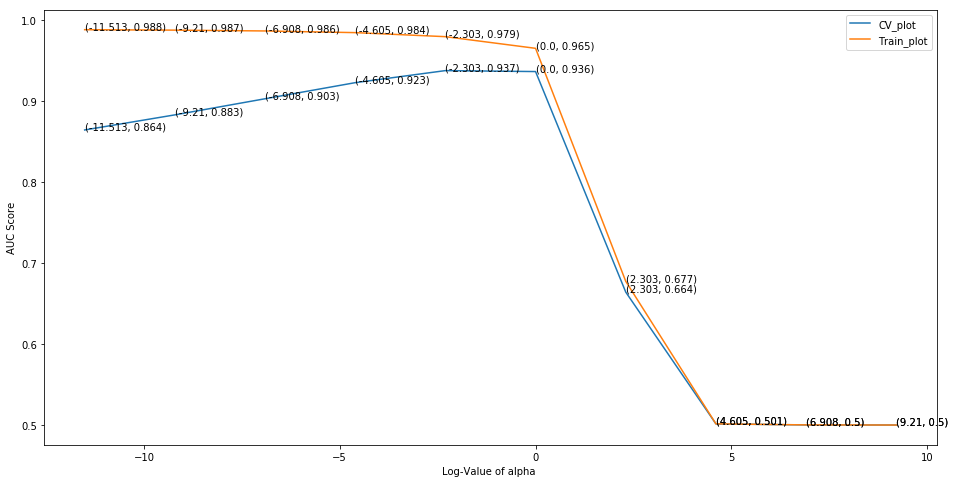

the AUC score for each alpha value is :  [0.864 0.883 0.903 0.923 0.937 0.936 0.664 0.501 0.5   0.5  ]


In [19]:
#Encode the class labels and find the optimal alpha
encoder = preprocessing.LabelEncoder()
enc = encoder.fit(y_train)
y_en_train= enc.transform(y_train)
y_en_test = enc.transform(y_test)

opt_alpha = find_optimal_alpha(X_trainf,y_en_train,5)

### [5.1.1] Top 10 important features of positive class from<font color='red'> SET 1</font>


The ROC_AUC score of the NB classifier for alpha = 0.100000 is 94.210795%
not great good like coffee love one taste tea product
The wordcloud for top 10 positive features are:


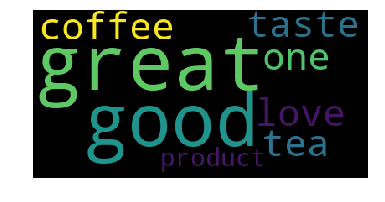

In [20]:
# Please write all the code with proper documentation
from wordcloud import WordCloud, STOPWORDS

y_pred,NB_opt = pred_test_data(X_trainf,y_en_train,X_testf,y_en_test,opt_alpha,vocab)

pos_class_prob_sorted = (abs(NB_opt.feature_log_prob_[1, :])).argsort()

#Create the top words for each class based on the prob scores obtained for each feature NOTE: we are leaving out first prob score as it corresponds to review length

pos_text = np.take(count_vect.get_feature_names(), pos_class_prob_sorted[1:11])

posi_text = " ".join(words for words in pos_text)

print(posi_text)
print("The wordcloud for top 10 positive features are:")
generate_wordcloud(posi_text)


### [5.1.2] Top 10 important features of negative class from<font color='red'> SET 1</font>

The wordcloud for top 10 negative features are:


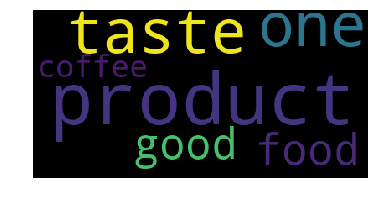

In [109]:
# Please write all the code with proper documentation
neg_class_prob_sorted = (abs(NB_opt.feature_log_prob_[0, :])).argsort()

#Create the top words for each class based on the prob scores obtained for each feature NOTE: we are leaving out first prob score as it corresponds to review length
neg_text = np.take(count_vect.get_feature_names(), neg_class_prob_sorted[1:11])
nega_text = " ".join(words for words in neg_text)

print("The wordcloud for top 10 negative features are:")
generate_wordcloud(nega_text)

Confusion matrix is :  [[ 3896   780]
 [ 1800 23524]]
The True Positive value is:   23524
The True Negative value is:   3896
The False Positive value is:   1800
The False Negative value is:   780


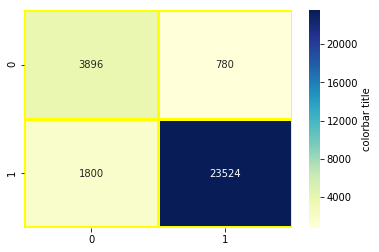

In [110]:
confusion_heatmap(y_en_test,y_pred)

In [111]:
#determining metrics precision,recall,f-1 scores for our model
metric_score(y_en_test,y_pred)

The precision score for our model is:  0.9679065174456879
The f1 score for our model is:  0.948013218344483
The recall score for our model is:  0.9289211814879166
The accuracy of our model is:  0.914


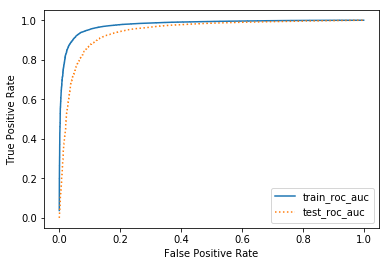

In [112]:
ytrain_prob = NB_opt.predict_proba(X_trainf)
ytrain_prob = ytrain_prob[:, 1]

ytest_prob = NB_opt.predict_proba(X_testf)
ytest_prob = ytest_prob[:,1]
#get the class probabilities for train and test to plot the roc curve 
plot_roc_curve(y_en_train,ytrain_prob,y_en_test,ytest_prob,'-',':',"train_roc_auc","test_roc_auc")

Conclusion:
1. Naive Bayes using 5-fold validation was performed on a sample dataset of AFF for Bag of words. We have chosen Multinomial NB becuase our feature vector BOW count based. 
2. We chose the standard 70-30 split i.e. 70% as train data and 30% as test data.
3. The optimal alpha in was computed to be 0.1 based on AUC score as our metric.
4. Confusion matrix was plotted for the same. We got True Negative value of 3896 and True Positive value of 23524. we also get a high false positive value of 1800 meaning lesser misclassification of the negative class.
5. The accuracy,precision, recall and f1 scores are 91.4% , 96.79%, 92.89% and 94.80 % respectively. This means that we are performing remarkabely well in Postive class classification.
6. Also NB helps us in getting the feature importance, we got the top 10 words that helped us in classifying a given point for both classes. A word cloud was generated for the same.
7. It could be noted that the first highest prob belonged to review length(which means our feature engineering did help), hence we took the next 10 important features! 


## [5.2] Applying Naive Bayes on TFIDF,<font color='red'> SET 2</font>

In [113]:
# Please write all the code with proper documentation
X_train, X_test, y_train, y_test = cross_validation.train_test_split(final, label, test_size=0.3, random_state=0)
#Converting text into vector using tfidf vectorizer
tf_idf_vect = TfidfVectorizer(ngram_range=(1,2))
vocab = tf_idf_vect.fit(X_train['combined_text'].values)
X_train_tfidf = vocab.transform(X_train['combined_text'].values)
X_test_tfidf = vocab.transform(X_test['combined_text'].values)

X_trainf = sparse.vstack((X_train_tfidf.T,X_train_len.T)).T
X_testf = sparse.vstack((X_test_tfidf.T,X_test_len.T)).T

print(X_trainf.shape)

(70000, 1158145)



The optimal value of alpha is 0.010000.


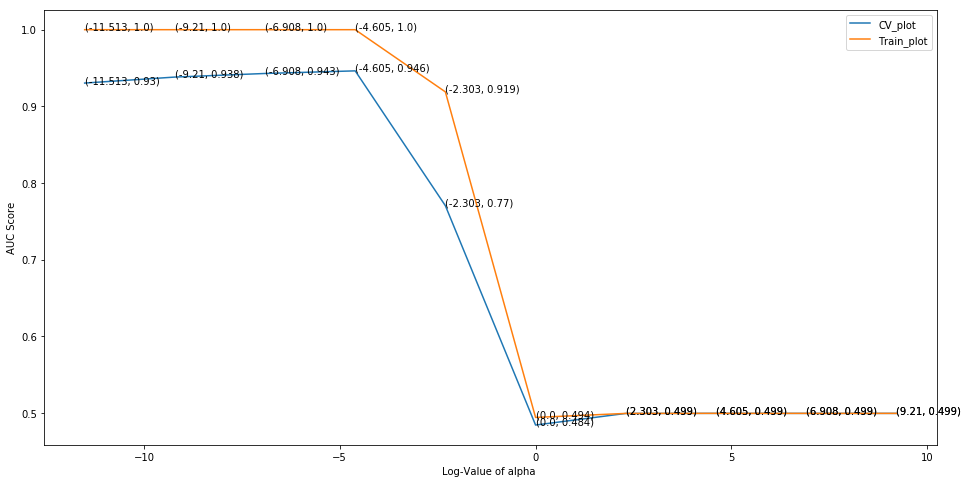

the AUC score for each alpha value is :  [0.93  0.938 0.943 0.946 0.77  0.484 0.499 0.499 0.499 0.499]


In [114]:
#Plot MSE for each value of alpha
opt_alpha = find_optimal_alpha(X_trainf,y_en_train,5)

### [5.2.1] Top 10 important features of positive class from<font color='red'> SET 2</font>


The ROC_AUC score of the NB classifier for alpha = 0.010000 is 96.783151%
The wordcloud for top 10 positive features are:


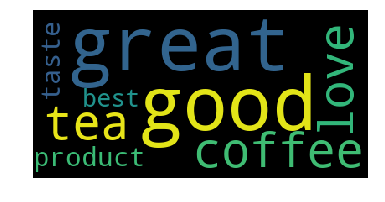

In [115]:
# Please write all the code with proper documentation
y_pred,NB_opt = pred_test_data(X_trainf,y_en_train,X_testf,y_en_test,opt_alpha,tf_idf_vect)
type(y_pred)

pos_class_prob_sorted = (abs(NB_opt.feature_log_prob_[1, :])).argsort()

pos_text = np.take(tf_idf_vect.get_feature_names(), pos_class_prob_sorted[1:11])

posi_text = " ".join(words for words in pos_text)

#pass the list of top 10 words for each class to wordcloud
print("The wordcloud for top 10 positive features are:")
generate_wordcloud(posi_text)

### [5.2.2] Top 10 important features of negative class from<font color='red'> SET 2</font>

The wordcloud for top 10 negative features are:


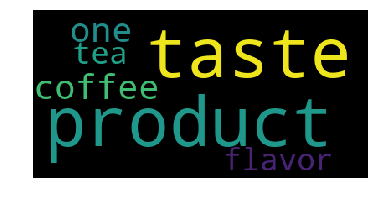

In [116]:
# Please write all the code with proper documentation
neg_class_prob_sorted = (abs(NB_opt.feature_log_prob_[0, :])).argsort()

neg_text = np.take(tf_idf_vect.get_feature_names(), neg_class_prob_sorted[1:11])
nega_text = " ".join(words for words in neg_text)

print("The wordcloud for top 10 negative features are:")
generate_wordcloud(nega_text)

Confusion matrix is :  [[ 3466  1210]
 [  613 24711]]
The True Positive value is:   24711
The True Negative value is:   3466
The False Positive value is:   613
The False Negative value is:   1210


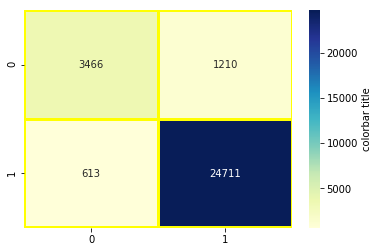

In [117]:
confusion_heatmap(y_en_test,y_pred)

In [118]:
#determining metrics precision,recall,f-1 scores for our model

metric_score(y_en_test,y_pred)

The precision score for our model is:  0.9533197021719841
The f1 score for our model is:  0.964425797638794
The recall score for our model is:  0.975793713473385
The accuracy of our model is:  0.9392333333333334


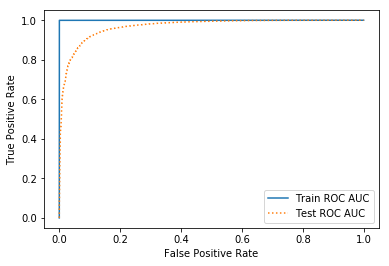

In [119]:
ytrain_prob = NB_opt.predict_proba(X_trainf)
ytrain_prob = ytrain_prob[:, 1]

ytest_prob = NB_opt.predict_proba(X_testf)
ytest_prob = ytest_prob[:,1]

plot_roc_curve(y_en_train,ytrain_prob,y_en_test,ytest_prob,'-',':',"Train ROC AUC","Test ROC AUC")

Conclusion:
1. Naive Bayes using 5-fold validation was performed on a sample dataset of AFF for Bag of words.We have chosen Multinomial NB becuase our feature vector TFIDF has real valued fractions. 
2. We chose the standard 70-30 split i.e. 70% as train data and 30% as test data.
3. The optimal alpha in was computed to be 0.01 based on AUC score as our metric.
4. Confusion matrix was plotted for the same. We got True Negative value of 3466 and True Positive value of 24711. we also get a low false negative value of 1210.
5. The accuracy,precision, recall and f1 scores are 92.92 % , 95.33%, 97.57% and 96.44 % respectively. This means that we are performing remarkabely well in Postive class classification. We get a very high recall value which suggests that most of our classification were correct. 
6. Also NB helps us in getting the feature importance, we got the top 10 words that helped us in classifying a given point for both classes. A word cloud was generated for the same.
7. It could be noted that the first highest prob belonged to review length, hence we took the next 10 important features! 


# [6] Conclusions

In [120]:
# Please compare all your models using Prettytable library

from prettytable import PrettyTable
    
x = PrettyTable(["METRIC", "B.O.W", "TF-IDF"])

x.add_row(["Alpha",.1, .01])
x.add_row(["True Positive",23524, 24711])
x.add_row(["True Negative",3896, 3466])
x.add_row(["Accuracy",91.4, 93.92])
x.add_row(["Precision",96.79, 95.33])
x.add_row(["Recall",92.89, 97.57])
x.add_row(["F1 Scores",94.80, 96.44])

print(x)

+---------------+-------+--------+
|     METRIC    | B.O.W | TF-IDF |
+---------------+-------+--------+
|     Alpha     |  0.1  |  0.01  |
| True Positive | 23524 | 24711  |
| True Negative |  3896 |  3466  |
|    Accuracy   |  91.4 | 93.92  |
|   Precision   | 96.79 | 95.33  |
|     Recall    | 92.89 | 97.57  |
|   F1 Scores   |  94.8 | 96.44  |
+---------------+-------+--------+
